In [3]:
import pandas as pd
import numpy as np
from scipy.stats import norm
import ast  # To parse stringified lists/dictionaries
import matplotlib.pyplot as plt


             time    symbol  side    price       fee feeAsset     quantity  \
0   1718641182000  DOGEUSDT   BUY  0.12670 -2.438519     USDT  12192.59440   
1   1718381884000  DOGEUSDT  SELL  0.13504 -0.084130     USDT    168.25984   
2   1718381884000  DOGEUSDT  SELL  0.13504 -0.493909     USDT    987.81760   
3   1718381884000  DOGEUSDT  SELL  0.13504 -0.337600     USDT    675.20000   
4   1718381884000  DOGEUSDT  SELL  0.13504 -1.145004     USDT   2290.00832   
5   1718381884000  DOGEUSDT  SELL  0.13504 -0.254956     USDT    509.91104   
6   1718381884000  DOGEUSDT  SELL  0.13504 -0.493909     USDT    987.81760   
7   1718381884000  DOGEUSDT  SELL  0.13505 -0.494080     USDT    988.16085   
8   1718381884000  DOGEUSDT  SELL  0.13505 -1.145089     USDT   2290.17790   
9   1718381884000  DOGEUSDT  SELL  0.13506 -0.675300     USDT   1350.60000   
10  1718381884000  DOGEUSDT  SELL  0.13506 -1.145174     USDT   2290.34748   
11  1718381884000  DOGEUSDT  SELL  0.13506 -0.150930     USDT   

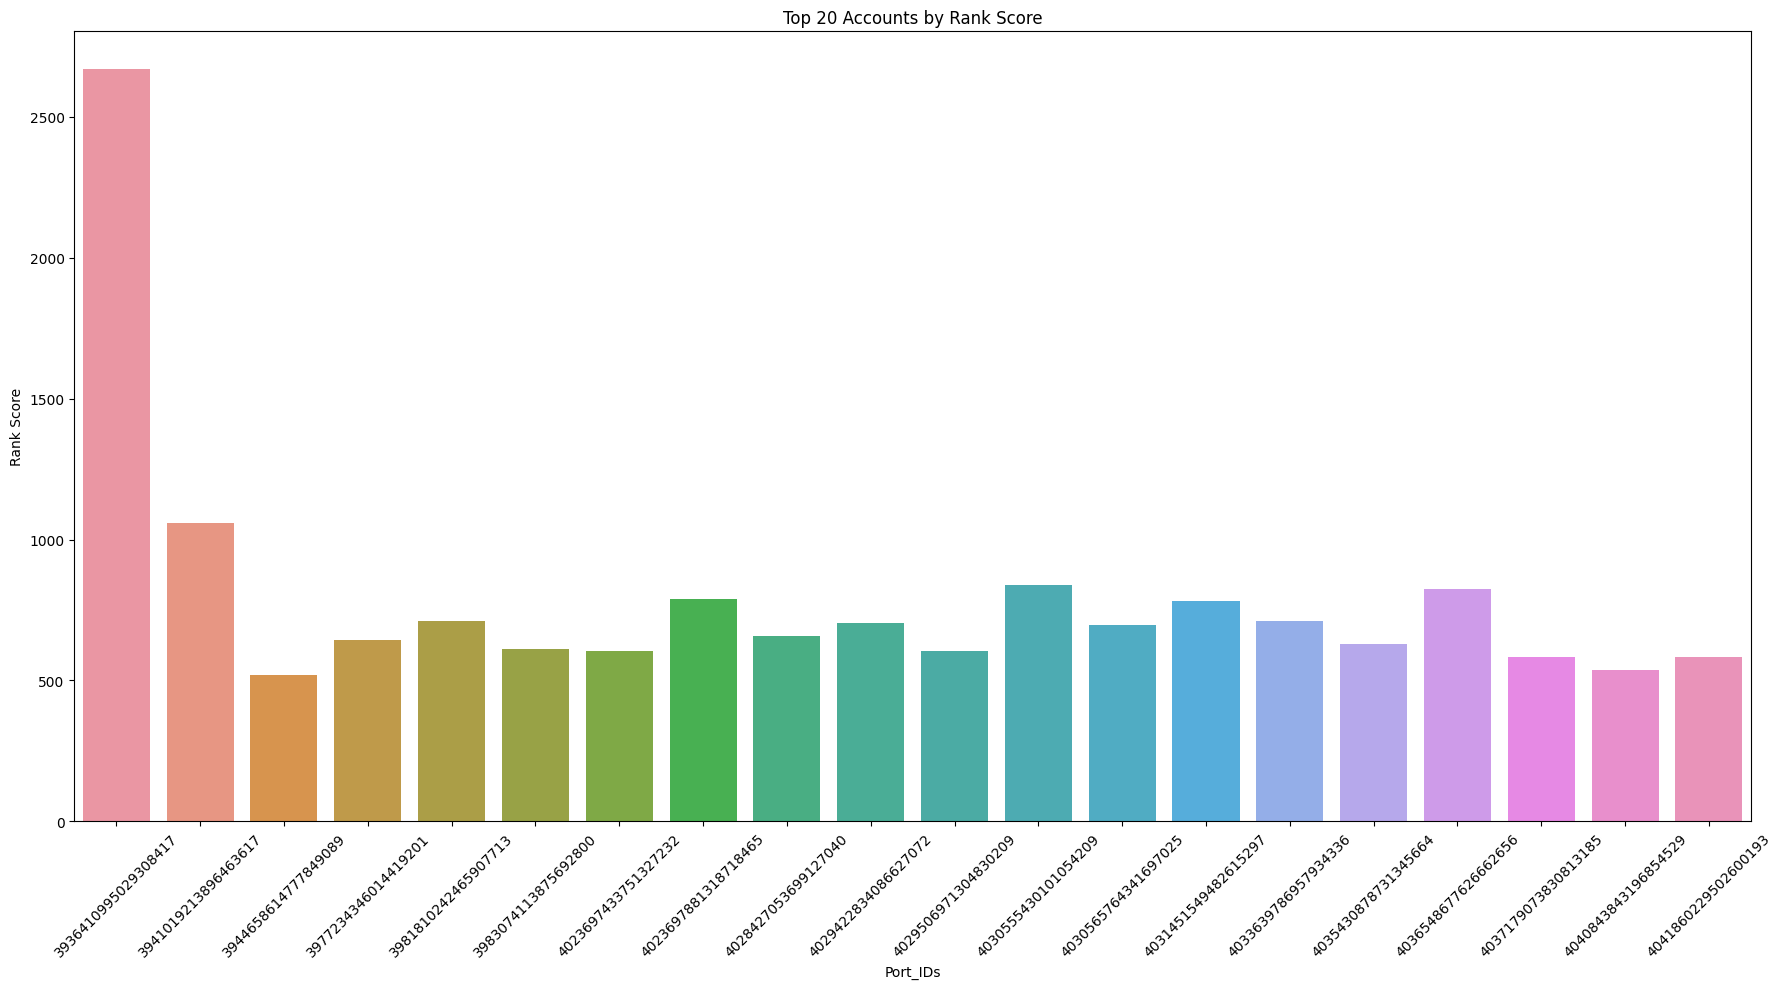

               Port_IDs  Total_PnL   Total_ROI  Sharpe_Ratio  Max_Drawdown  \
7   3936410995029308417  10681.514    0.000033      0.298984      0.000000   
8   3941019213896463617   4234.088    0.000192      0.087774     -2.435062   
23  4030555430101054209   3358.380    0.000123      0.324086      0.000000   
30  4036548677626662656   3296.877    0.000171      0.242677      0.000000   
17  4023697881318718465   3151.951    3.166872      0.275870      0.000000   
27  4031451549482615297   3124.541    0.005198      0.225302     -0.359971   
28  4033639786957934336   2848.142    0.000059      0.214412      0.000000   
12  3981810242465907713   2836.473    3.372943      0.197073     -0.000000   
19  4029422834086627072   2799.903   10.927289      0.511618      0.000000   
24  4030565764341697025   2789.878    0.011811      0.332899     -0.032148   
18  4028427053699127040   2633.024   -0.000394      0.264271     -0.092990   
11  3977234346014419201   2427.293  116.352200      0.304736    

In [4]:
import pandas as pd
import numpy as np
import ast
import matplotlib.pyplot as plt
import seaborn as sns

# Load the dataset
df = pd.read_csv('/kaggle/input/trade-data/TRADES_CopyTr_90D_ROI - TRADES_CopyTr_90D_ROI.csv')  # Update path if needed

# Ensure 'Trade_History' column is read as a string and parsed correctly
df['Trade_History'] = df['Trade_History'].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)

# Helper function to flatten the 'Trade_History'
def extract_trade_data(trade_history, port_id):
    trades = []
    for trade in trade_history:
        trade_data = trade.copy()
        trade_data['Port_IDs'] = port_id
        trades.append(trade_data)
    return trades
    
all_trades = []
for _, row in df.iterrows():
    if isinstance(row['Trade_History'], list):
        all_trades.extend(extract_trade_data(row['Trade_History'], row['Port_IDs']))

df_trades = pd.DataFrame(all_trades)

print(df_trades.head(20))

# Step 1: Calculate PnL
df_trades['PnL'] = df_trades['realizedProfit']

# Step 2: Calculate ROI
df_trades['Investment'] = df_trades['quantity'] * df_trades['price']
df_trades['ROI'] = (df_trades['PnL'] / df_trades['Investment']) * 100

# Step 3: Calculate Sharpe Ratio
sharpe_ratios = {}
for port_id, group in df_trades.groupby('Port_IDs'):
    mean_returns = group['PnL'].mean()
    std_dev_returns = group['PnL'].std()
    sharpe_ratios[port_id] = (mean_returns / std_dev_returns) if std_dev_returns != 0 else np.nan

# Step 4: Calculate Maximum Drawdown (MDD)
df_trades['cumulative_profit'] = df_trades.groupby('Port_IDs')['PnL'].cumsum()
df_trades['peak'] = df_trades.groupby('Port_IDs')['cumulative_profit'].cummax()
df_trades['drawdown'] = (df_trades['cumulative_profit'] - df_trades['peak']) / df_trades['peak']
max_drawdowns = df_trades.groupby('Port_IDs')['drawdown'].min()

# Step 5: Calculate Win Rate and Win Positions
df_trades['Win'] = df_trades['PnL'] > 0
win_positions = df_trades.groupby('Port_IDs')['Win'].sum()
total_positions = df_trades.groupby('Port_IDs').size()
win_rates = (win_positions / total_positions).round(2)

# Step 6: Combine metrics for ranking
metrics = pd.DataFrame({
    'Port_IDs': win_positions.index,
    'Total_PnL': df_trades.groupby('Port_IDs')['PnL'].sum().round(3),
    'Total_ROI': df_trades.groupby('Port_IDs')['ROI'].mean(),
    'Sharpe_Ratio': pd.Series(sharpe_ratios),
    'Max_Drawdown': max_drawdowns,
    'Win_Rate': win_rates,
    'Total_Positions': total_positions,
    'Win_Positions': win_positions
}).reset_index(drop=True)

# Weighted Scoring System
weights = {
    'Total_ROI': 0.3,
    'Total_PnL': 0.25,
    'Sharpe_Ratio': 0.2,
    'Win_Rate': 0.15,
    'Max_Drawdown': -0.1 
}

for metric, weight in weights.items():
    metrics[metric + '_Score'] = metrics[metric] * weight

metrics['Rank_Score'] = metrics[[metric + '_Score' for metric in weights]].sum(axis=1)

# Rank accounts
metrics = metrics.sort_values(by='Rank_Score', ascending=False)

# Save metrics to CSV
output_file = 'final_account_ranking.csv'
metrics.to_csv(output_file, index=False)

# Visualization
plt.figure(figsize=(18, 10))
sns.barplot(x=metrics['Port_IDs'].head(20), y=metrics['Rank_Score'].head(20))
plt.title('Top 20 Accounts by Rank Score')
plt.xlabel('Port_IDs')
plt.ylabel('Rank Score')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Top 20 Accounts
top_20_accounts = metrics.head(20)
print(top_20_accounts)
